<a href="https://colab.research.google.com/github/EricaSG/Capstone/blob/master/Primary_Capstone_Colorized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries and Data

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5581207742763521329, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6692571032904563026
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17631277438788123580
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4914487711676303422
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Use the TensorFlow backend
from tensorflow import keras

In [18]:
import warnings
warnings.filterwarnings('ignore')
import random 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from keras import layers
from keras.models import Sequential
from sklearn.model_selection import train_test_split, cross_val_predict
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import itertools
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.optimizers import Adam, Adadelta, Adagrad, SGD, RMSprop
from keras import initializers
from keras.constraints import unit_norm, min_max_norm
from keras.applications.inception_v3 import InceptionV3

In [9]:
!unzip -uq "/content/drive/My Drive/Colorized_Images.zip" -d "/content/drive/My Drive/"

In [ ]:
# Use if downloading from a local machine
# train_color = 'Colorized_Images/c_train/'
# val_color = 'Colorized_Images/c_val/'
# test_color = 'Colorized_Images/c_test/'

In [20]:
# Use if downloading from the cloud
train_color = '/content/drive/My Drive/Colorized_Images/c_train/'
val_color = '/content/drive/My Drive/Colorized_Images/c_val/'
test_color = '/content/drive/My Drive/Colorized_Images/c_test/'

# Preprocessing

## Read in & Normalize Images

In [21]:
# Resize all 15,200 images in the train directory
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(train_color,
                                                     target_size=(128,128), batch_size=15200)

Found 15198 images belonging to 2 classes.


In [22]:
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_color,
                                                     target_size=(128,128), batch_size=16)

Found 16 images belonging to 2 classes.


In [23]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_color,
                                                     target_size=(128,128), batch_size=624)

Found 622 images belonging to 2 classes.


## Generate Image & Label Sets

In [24]:
# Iterate through all of the images and create image-label datasets
train_images, train_labels = next(train_gen)

In [25]:
val_images, val_labels = next(val_gen)

In [26]:
test_images, test_labels = next(test_gen)

In [27]:
# Verify the class labels
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [28]:
# Recheck for Class Imbalance
u = np.unique(train_labels, return_counts=True)
np.asarray(u).T

array([[0.0000e+00, 1.5198e+04],
       [1.0000e+00, 1.5198e+04]])

## Check the Shape of the Images and Labels

In [29]:
print('Shape of Train Images: ', np.shape(train_images))
print('Shape of Train Labels: ', np.shape(train_labels))
print('Shape of Validation Images: ', np.shape(val_images))
print('Shape of Validation Labels: ', np.shape(val_labels))
print('Shape of Test Images: ', np.shape(test_images))
print('Shape of Test Labels: ', np.shape(test_labels))

Shape of Train Images:  (15198, 128, 128, 3)
Shape of Train Labels:  (15198, 2)
Shape of Validation Images:  (16, 128, 128, 3)
Shape of Validation Labels:  (16, 2)
Shape of Test Images:  (622, 128, 128, 3)
Shape of Test Labels:  (622, 2)


### Transform the labels to (m X 1) matrices

In [30]:
train_labels_final = np.reshape(train_labels[:,0], (15198,1))
np.shape(train_labels_final)

(15198, 1)

In [31]:
val_labels_final = np.reshape(val_labels[:,0], (16,1))
np.shape(val_labels_final)

(16, 1)

In [32]:
test_labels_final = np.reshape(test_labels[:,0], (622,1))
np.shape(test_labels_final)

(622, 1)

### Verify the Image and Label Pairs


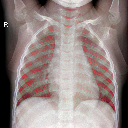

In [39]:
# Select a random image to verify
array_to_img(train_images[10])

In [40]:
# Return the respective label and verify that the label matches the image
train_labels_final[10, :]

array([1.], dtype=float32)

## Address Validation & Test Datasets

In [35]:
xtrain, xval, ytrain, yval = train_test_split(train_images, train_labels_final, train_size=0.9, test_size=0.1, random_state=42)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, train_size=0.78, random_state=42)

# Modeling

## Model 1: Model128_drop

In [41]:
random.seed(123)

model1_color = Sequential()

model1_color.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_constraint=unit_norm(), input_shape=(128, 128, 3)))
model1_color.add(layers.MaxPooling2D((2, 2)))

model1_color.add(layers.Conv2D(64, (4, 4), activation='relu'))
model1_color.add(layers.MaxPooling2D((2, 2)))

model1_color.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1_color.add(layers.MaxPooling2D((2,2)))
model1_color.add(Dropout(0.4))

model1_color.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1_color.add(layers.MaxPooling2D((2,2)))

model1_color.add(layers.Conv2D(256, (3, 3), activation='relu'))
model1_color.add(layers.MaxPooling2D((2,2)))
model1_color.add(Dropout(0.4))

# Flattening- Convert 2D matrix to a 1D vector
model1_color.add(layers.Flatten())
model1_color.add(layers.Dense(512, activation = 'relu'))
model1_color.add(Dropout(0.2))
model1_color.add(layers.Dense(1, activation='sigmoid'))

In [42]:
model1_color.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0

In [43]:
model1_color.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
# Execute "early stopping" to stop the model when the loss has stopped improving
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='model1_color.h5', monitor='val_accuracy', save_best_only=True)]

In [47]:
results1 = model1_color.fit(train_images, train_labels_final, epochs=100, batch_size=1500, callbacks=early_stopping, validation_data=(val_images, val_labels_final))

Epoch 1/100
11/11 [==============================] - 5s 456ms/step - loss: 1.0999 - accuracy: 0.5031 - val_loss: 0.6820 - val_accuracy: 0.5625
Epoch 2/100
11/11 [==============================] - 4s 377ms/step - loss: 0.5211 - accuracy: 0.7150 - val_loss: 1.3641 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 4s 371ms/step - loss: 0.0570 - accuracy: 0.9924 - val_loss: 9.6966 - val_accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 4s 380ms/step - loss: 0.0078 - accuracy: 0.9997 - val_loss: 17.0088 - val_accuracy: 0.5000
Epoch 5/100
11/11 [==============================] - 4s 378ms/step - loss: 0.0087 - accuracy: 0.9997 - val_loss: 14.1128 - val_accuracy: 0.5625
Epoch 6/100
11/11 [==============================] - 4s 384ms/step - loss: 0.0074 - accuracy: 0.9997 - val_loss: 11.6745 - val_accuracy: 0.5000
Epoch 7/100
11/11 [==============================] - 4s 394ms/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 9.1250 - val_accuracy: 0.5

### Evaluate: Model1_color

In [49]:
model1_color.evaluate(train_images, train_labels_final)

475/475 [==============================] - 3s 6ms/step - loss: 0.0047 - accuracy: 0.9998


[0.004683946259319782, 0.9998025894165039]

In [50]:
model1_color.evaluate(val_images, val_labels_final)

1/1 [==============================] - 0s 1ms/step - loss: 7.9640 - accuracy: 0.5000


[7.9639763832092285, 0.5]

In [51]:
def visualize_training_results(results):
    """
   1 Input: The Training and 
    Validation/Testing Dictionary 
    of Loss and Accuracy
    
    Output: 2 Plots of Loss vs. Epochs
    and Accuracy vs. Epochs
    """
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

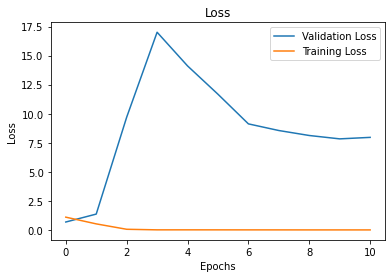

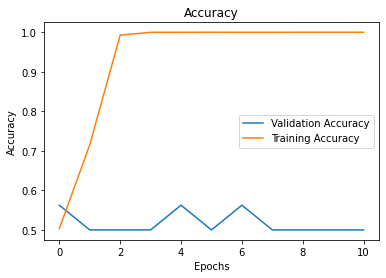

In [52]:
visualize_training_results(results1)

In [53]:
# Make Predictions
preds1 = model1_color.predict(val_images)

In [54]:
predictions1 = preds1 > 0.5

In [55]:
# Print the classification report showing the metrics Recall, Precision, and F1-Score
classification_report = classification_report(val_labels_final, predictions1)
classification_report

'              precision    recall  f1-score   support\n\n         0.0       0.50      0.25      0.33         8\n         1.0       0.50      0.75      0.60         8\n\n    accuracy                           0.50        16\n   macro avg       0.50      0.50      0.47        16\nweighted avg       0.50      0.50      0.47        16\n'

In [58]:
# Plot a confusion matrix
def plot_confusion_matrix(labels, preds):
    """
    Input: Validation/Testing Labels and
    model predictions
    
    Output: A confusion matrix
    
    """
    
    cnf_matrix = confusion_matrix(labels, preds)

    # Create the basic confusion matrix
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    y = train_gen.class_indices
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')

    # Add a legend
    plt.colorbar()
    plt.show()

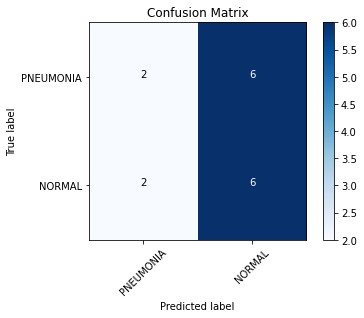

In [59]:
plot_confusion_matrix(val_labels_final, predictions1)

# Model 2: Dropout Regularization (Model 4)

## Model 3: Model_short

In [93]:
random.seed(123)

model_short = Sequential()

model_short.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_constraint=unit_norm(), input_shape=(128, 128, 3)))
model_short.add(layers.MaxPooling2D((2, 2)))
model_short.add(Dropout(0.4))

model_short.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_short.add(layers.MaxPooling2D((2,2)))
model_short.add(Dropout(0.4))

# Flattening- Convert 2D matrix to a 1D vector
model_short.add(layers.Flatten())
model_short.add(layers.Dense(512, activation = 'relu'))
model_short.add(Dropout(0.2))
model_short.add(layers.Dense(1, activation='sigmoid'))

In [94]:
model_short.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 125, 125, 32)      1568      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 57600)            

In [95]:
model_short.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
save_model = ModelCheckpoint(filepath='model_colorshort.h5', monitor='val_accuracy', save_best_only=True)

In [97]:
val_images.shape

(16, 128, 128, 3)

In [98]:
test_results2 = model_short.fit(train_images, train_labels_final, epochs=11, batch_size=256, callbacks=save_model, validation_data=(val_images, val_labels_final))

Epoch 1/11
60/60 [==============================] - 6s 97ms/step - loss: 11.0957 - accuracy: 0.5069 - val_loss: 0.6780 - val_accuracy: 0.5000
Epoch 2/11
60/60 [==============================] - 5s 77ms/step - loss: 0.4212 - accuracy: 0.8679 - val_loss: 0.6590 - val_accuracy: 0.5000
Epoch 3/11
60/60 [==============================] - 5s 77ms/step - loss: 0.4004 - accuracy: 0.9015 - val_loss: 0.6533 - val_accuracy: 0.5000
Epoch 4/11
60/60 [==============================] - 5s 76ms/step - loss: 0.3940 - accuracy: 0.8964 - val_loss: 0.6504 - val_accuracy: 0.5000
Epoch 5/11
60/60 [==============================] - 6s 95ms/step - loss: 0.3830 - accuracy: 0.8981 - val_loss: 0.6374 - val_accuracy: 0.6875
Epoch 6/11
60/60 [==============================] - 5s 75ms/step - loss: 0.3739 - accuracy: 0.8983 - val_loss: 0.6375 - val_accuracy: 0.6875
Epoch 7/11
60/60 [==============================] - 5s 75ms/step - loss: 0.3679 - accuracy: 0.8958 - val_loss: 0.6357 - val_accuracy: 0.6875
Epoch 8/11
6